## Taller 1 - Reconstrucción 3D a partir de imágenes usando SfM.

### Introducción a la Visión por Computadora

### Luceth Argote

### Importar e instalar librerías.

In [ ]:
!pip install pycolmap

In [ ]:
!pip install open3d

In [172]:
import numpy as np
import cv2 as cv
import glob
import pycolmap
import open3d as o3d
import shutil

from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Calibración de la cámara.

In [173]:
chessboardSize = (7,7)

frameSize = (358, 268)

In [174]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [175]:
objp = np.zeros((chessboardSize[0]*chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0], 0:chessboardSize[1]].T.reshape(-1, 2)

In [176]:
objPoints = []
imgPoints = []

In [177]:
chess = glob.glob('chess/*.jpeg')

In [178]:
for image in chess:
    img = cv.imread(image)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #Detectar esquinas del tablero
    ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)

    if ret == True:
        objPoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgPoints.append(corners)

        # Dibujar las esquinas detectadas
        cv.drawChessboardCorners(img, chessboardSize, corners2, ret)
        #cv.imshow("Chessboard", img)
        #cv2_imshow(img)
        cv.waitKey(1000)

cv.destroyAllWindows()

In [179]:
#Calibración
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)

#Guardar parámetros de calibración
np.savez("calibration_data.npz", mtx=mtx, dist=dist)

In [180]:
#Cargar los parámetros de calibración
calib_data = np.load("calibration_data.npz")
mtx = calib_data["mtx"]
dist = calib_data["dist"]

### Pre-procesamiento de imágenes, Detección de Características y Emparejamiento.

In [181]:
#Cargar las imagenes del cubo
#cubo = glob.glob('cubo/*.jpeg')
cubo = glob.glob('cubo2/*.jpeg')

Detección de características usando SIFT.

In [182]:
#Inicializar SIFT
sift = cv.SIFT_create()

keypoints_list = []
descriptors_list = []
loaded_images = []

cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM (3).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.31 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.32 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.32 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.31 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.28 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.34 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.29 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.32 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.31 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.29 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM (3).jpeg


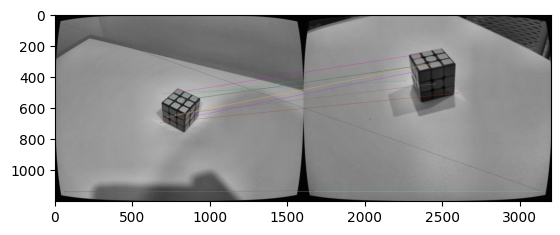

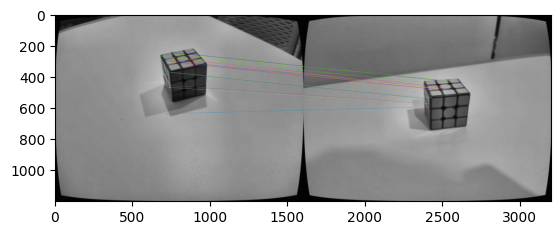

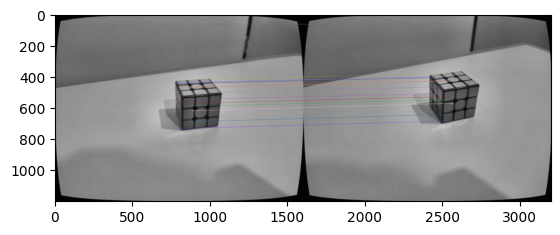

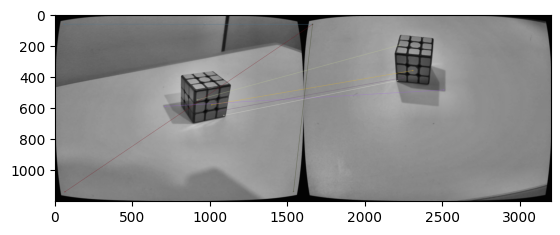

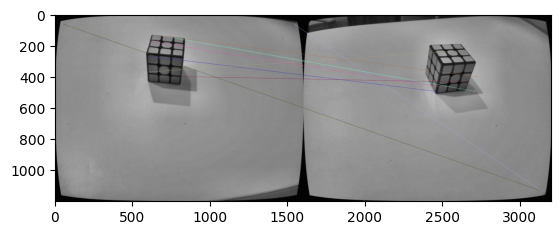

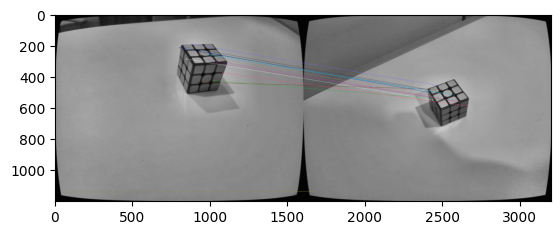

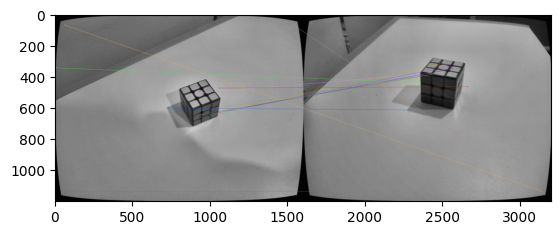

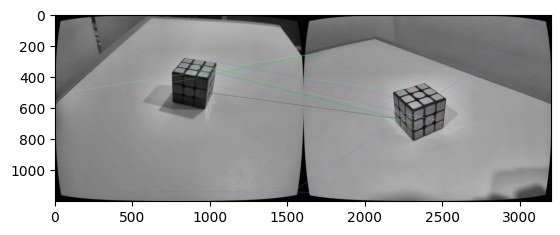

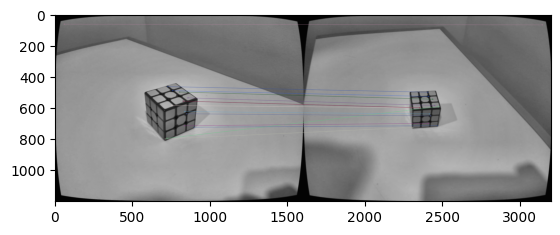

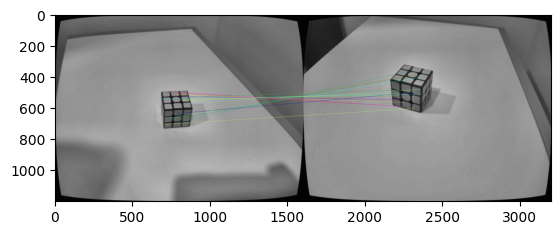

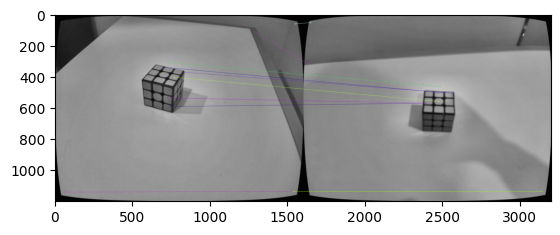

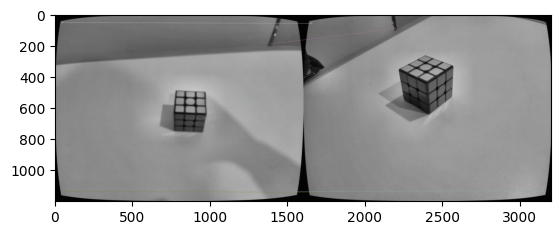

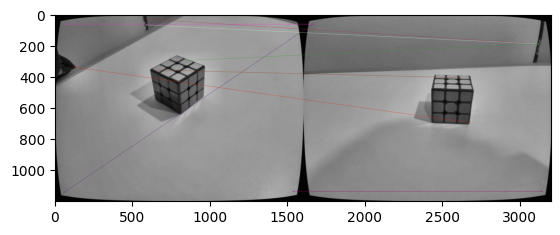

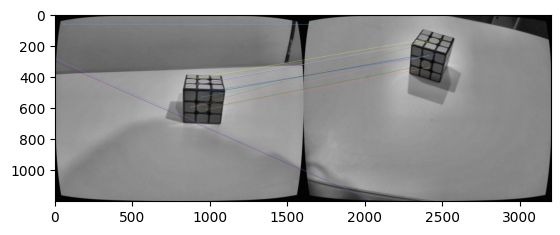

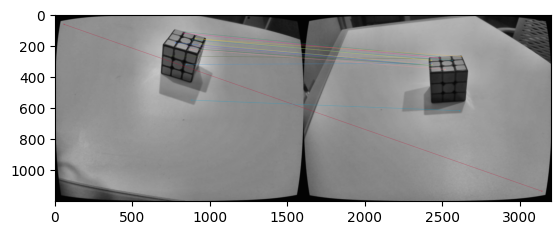

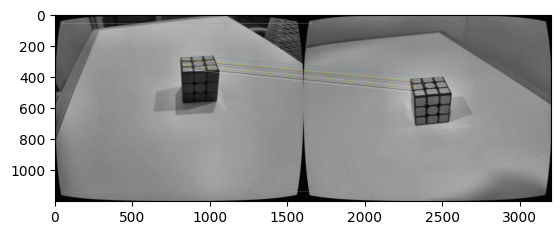

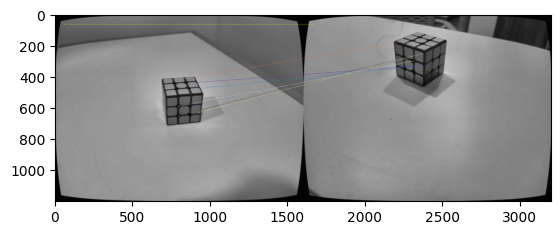

In [183]:
for image in cubo:
    print(image)
    img = cv.imread(image)
    h, w = img.shape[:2]

    #Corregir distorsión
    new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undistorted = cv.undistort(img, mtx, dist, None, new_camera_mtx)

    #Escala de grises
    gray = cv.cvtColor(undistorted, cv.COLOR_BGR2GRAY)

    #Mejoras de contraste
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    #Reducción de ruido
    denoised = cv.bilateralFilter(cl1, d=9, sigmaColor=75, sigmaSpace=75)

    #Detectar las esquinas
    dst = cv.cornerHarris(denoised, 2, 3, 0.04)

    dst = cv.dilate(dst, None)

    #Seleccionar las esquinas más destacadas
    corners = np.argwhere(dst > 0.01 * dst.max())

    if len(corners) >= 9:  # Si se detectan al menos 9 puntos
        #Dibujar esquinas detectadas
        for x, y in corners[:9]:
            cv.circle(undistorted, (y, x), 5, (0, 255, 0), -1)

    #Aplicar SIFT sobre la imagen
    keypoints, descriptors = sift.detectAndCompute(denoised, None)

    #Guardar resultados
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    loaded_images.append(denoised)

# Emparejamiento de características con FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

for i in range(len(loaded_images) - 1):
    img1, img2 = loaded_images[i], loaded_images[i + 1]
    kp1, kp2 = keypoints_list[i], keypoints_list[i + 1]
    des1, des2 = descriptors_list[i], descriptors_list[i + 1]

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Dibujar los mejores 20 emparejamientos
    img_matches = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:15], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #cv2_imshow(img_matches)
    #cv.waitKey(500)
    plt.imshow(img_matches)
    plt.show()

cv.destroyAllWindows()

### Estimación de la matriz fundamental y la matriz escencial.

In [184]:
#Listas para almacenar puntos emparejados
pts1 = []
pts2 = []

for i in range(len(loaded_images) - 1):
    kp1, kp2 = keypoints_list[i], keypoints_list[i + 1]
    #matches = bf.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)
    matches = flann.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    #Extraer coordenadas de los puntos clave emparejados
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    #Guardar los puntos de correspondencia
    pts1.append(src_pts)
    pts2.append(dst_pts)

pts1 = np.concatenate(pts1)
pts2 = np.concatenate(pts2)

#Calcular la matriz fundamental
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

In [185]:
#Calcular la matriz esencial
E = mtx.T @ F @ mtx

In [186]:
#Descomposición de la Matriz Escencial
_, R, t, mask = cv.recoverPose(E, pts1, pts2, mtx)

In [187]:
#Construcción de las matrices de Proyección.
P1 = mtx @ np.hstack((np.eye(3), np.zeros((3,1))))  # [I | 0]
P2 = mtx @ np.hstack((R, t))  # [R | t]

In [188]:
#Triangulación para obtener los puntos 3D
points_4D = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)

points_3D = points_4D[:3] / points_4D[3]

In [189]:
print("Matriz Fundamental (F):\n", F)
print("\nMatriz Esencial (E):\n", E)
print("\nMatriz de Rotación (R):\n", R)
print("\nVector de Traslación (t):\n", t)
print("\nPuntos 3D reconstruidos:\n", points_3D.T)

Matriz Fundamental (F):
 [[ 5.68804356e-06  7.94547127e-05  2.47746539e-02]
 [-7.52162499e-05  2.79719671e-06  7.26143824e-02]
 [-3.40211542e-02 -8.25556193e-02  1.00000000e+00]]

Matriz Esencial (E):
 [[   8.864692    123.64777394   97.01055159]
 [-117.05185944    4.34665882   18.61757356]
 [ -94.11514004  -22.58667118   -5.73576879]]

Matriz de Rotación (R):
 [[ 9.97743140e-01 -5.79429599e-02  3.39299135e-02]
 [ 5.79333663e-02  9.98319649e-01  1.26662555e-03]
 [-3.39462914e-02  7.01907155e-04  9.99423412e-01]]

Vector de Traslación (t):
 [[-0.16301823]
 [ 0.61070616]
 [-0.7748955 ]]

Puntos 3D reconstruidos:
 [[-1.82512254e-01 -4.98384714e-01  6.23966873e-01]
 [-2.11101219e-01 -3.56480449e-01  3.98916662e-01]
 [-1.55408812e+01  1.14235973e+01  2.67836952e+01]
 [-4.67549264e-02 -2.38536671e-01 -2.87297845e+00]
 [ 2.73295665e+00  2.43867302e+00 -2.38004551e+01]
 [ 1.24457330e-01 -5.63031361e-02 -1.65162575e+00]
 [ 1.29376039e-01  1.12866737e-01 -2.38836813e+00]
 [ 1.98999718e-01  2.524

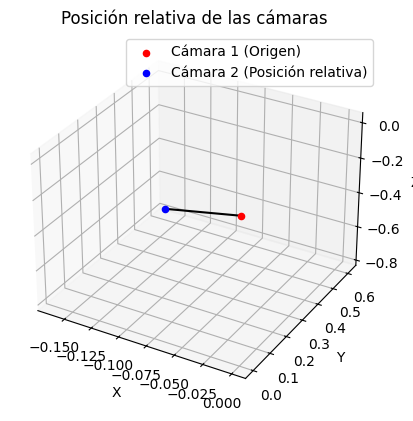

In [190]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Puntos de referencia de las cámaras
camera1 = np.array([0, 0, 0])  # Primera cámara en el origen
camera2 = t.flatten()  # Segunda cámara trasladada según t

# Dibujar las cámaras
ax.scatter(*camera1, c='r', marker='o', label="Cámara 1 (Origen)")
ax.scatter(*camera2, c='b', marker='o', label="Cámara 2 (Posición relativa)")

# Dibujar una línea entre ambas cámaras
ax.plot([camera1[0], camera2[0]], [camera1[1], camera2[1]], [camera1[2], camera2[2]], 'k-')

# Configuración del gráfico
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.title("Posición relativa de las cámaras")
plt.show()

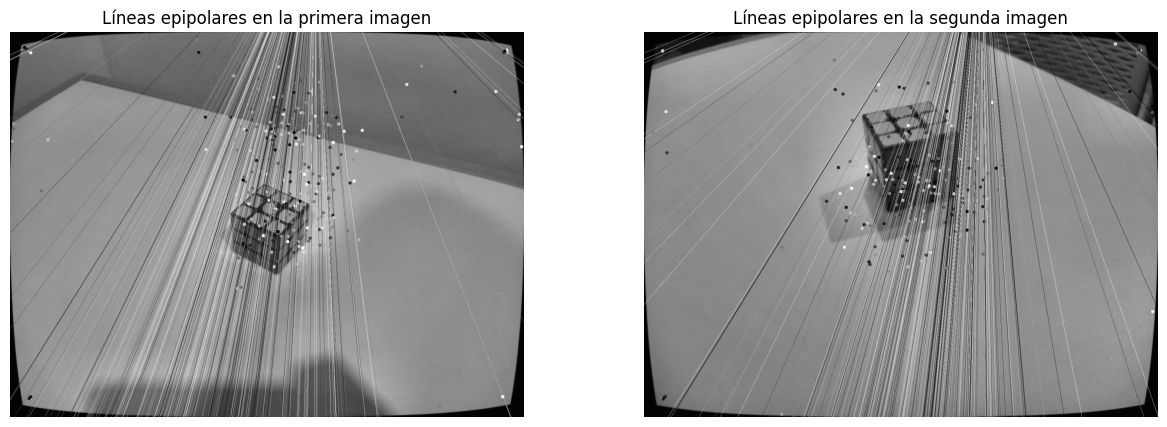

In [195]:
def draw_epilines(img1, img2, pts1, pts2, F):
    """Dibuja las líneas epipolares en ambas imágenes."""

    def draw_lines(img, lines, pts):
        """Dibuja líneas epipolares en la imagen con sus puntos correspondientes."""
        img = img.copy()
        for r, pt in zip(lines, pts):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2] / r[1]])  # Punto en el borde izquierdo
            x1, y1 = map(int, [img.shape[1], -(r[2] + r[0] * img.shape[1]) / r[1]])  # Punto en el borde derecho
            img = cv.line(img, (x0, y0), (x1, y1), color, 1)
            img = cv.circle(img, tuple(pt.astype(int)), 5, color, -1)
        return img

    # Calcular líneas epipolares
    lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
    lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

    # Dibujar líneas epipolares en ambas imágenes
    img1_with_lines = draw_lines(img1, lines1, pts1)
    img2_with_lines = draw_lines(img2, lines2, pts2)

    # Mostrar ambas imágenes
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(cv.cvtColor(img1_with_lines, cv.COLOR_BGR2RGB))
    axs[0].set_title("Líneas epipolares en la primera imagen")
    axs[0].axis("off")

    axs[1].imshow(cv.cvtColor(img2_with_lines, cv.COLOR_BGR2RGB))
    axs[1].set_title("Líneas epipolares en la segunda imagen")
    axs[1].axis("off")

    plt.show()

draw_epilines(loaded_images[0], loaded_images[1], pts1, pts2, F)

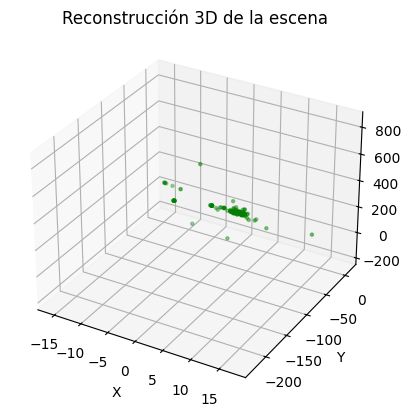

In [194]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[0], points_3D[1], points_3D[2], c='g', marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Reconstrucción 3D de la escena")
plt.show()